# Data loading

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

In [2]:
jar = pd.read_csv('clean_data.csv')

fdData = [[] for _ in range(7)]
fdVals = jar['FD'].unique()

for i, val in enumerate(fdVals):
    fd = jar[jar['FD'] == val]
    fd = fd.drop(['FD', 'fuel_gas_swelling'], axis=1)
    fdData[i] = fd

In [3]:
hi_data = fdData[-1]

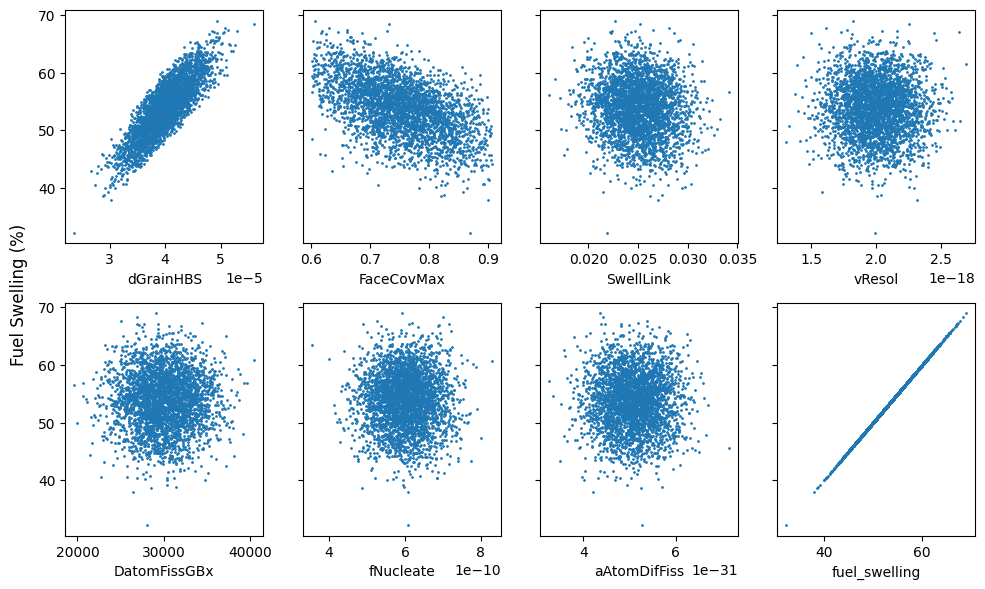

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(hi_data.iloc[:,i], hi_data.iloc[:,7], s=1)
    ax.set_xlabel(hi_data.columns[i])

fig.supylabel('Fuel Swelling (%)')
plt.tight_layout()
plt.show()

# Train/test split

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
feat_ind = list(range(7))
features = hi_data.iloc[:, feat_ind]
xscaler = MinMaxScaler()
X = xscaler.fit_transform(features)
y = hi_data['fuel_swelling']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Convenience functions

In [8]:
def lin_coef_cept(mod):
    print(
        ' coeffs: ',
        mod.coef_, '\n',
        'intercept: ',
        mod.intercept_
    )

In [9]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def mod_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(
        ' R2: ', r2, '\n',
        'RMSE: ', rmse, '\n',
        'MAE: ', mae
    )

In [10]:
def pred_vs_actual(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    plt.scatter(y_test, y_pred)
    plt.plot(list(range(30, 70)), list(range(30, 70)),
            color='k', label='y=x')
    
    plt.xlabel('DART prediction (swelling %)')
    plt.ylabel('Surrogate prediction (swelling %)')
    plt.legend()
    plt.show()

# Linear (OLS)

In [11]:
from sklearn import linear_model

 coeffs:  [ 3.32077011e+01 -1.15098683e+01 -3.70051230e+00 -1.33183272e-15
  1.81245713e-01  1.93481033e-02 -1.46434539e-28] 
 intercept:  44.49165503999078
 R2:  0.9970846062553819 
 RMSE:  0.2534527955169139 
 MAE:  0.17350338094342774


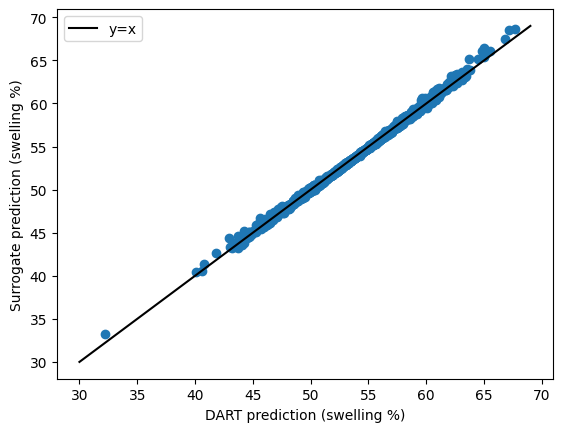

In [12]:
reg_lin = linear_model.LinearRegression().fit(X_train, y_train)

lin_coef_cept(reg_lin)
mod_metrics(reg_lin, X_test, y_test)
pred_vs_actual(reg_lin, X_test, y_test)

# Lasso

 alpha:  0.0005531773475918996
 coeffs:  [ 33.17167238 -11.49840032  -3.67290108  -0.           0.15526971
   0.           0.        ] 
 intercept:  44.5133267596561
 R2:  0.9970918098647723 
 RMSE:  0.2531394752050807 
 MAE:  0.17320340758842637


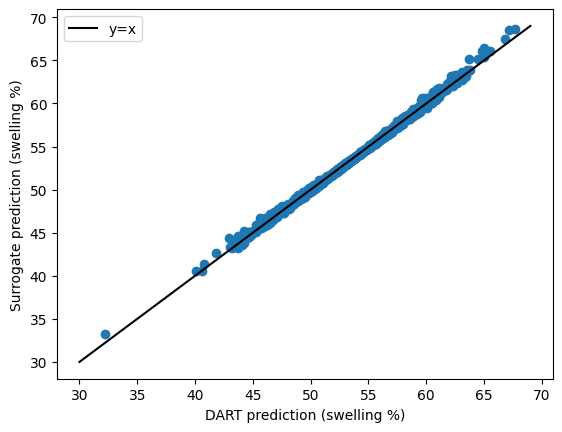

In [13]:
reg_lasso = linear_model.LassoCV(
        cv=5, random_state=42
    ).fit(X_train, y_train)

print(' alpha: ', reg_lasso.alpha_)
lin_coef_cept(reg_lasso)
mod_metrics(reg_lasso, X_test, y_test)
pred_vs_actual(reg_lasso, X_test, y_test)

# Lasso LARS

 alpha:  0.0005531773475918996
 coeffs:  [ 33.18806429 -11.50363122  -3.68538079   0.           0.1670242
   0.           0.        ] 
 intercept:  44.508018214948386
 R2:  0.9970877012455484 
 RMSE:  0.25331822669389853 
 MAE:  0.17333692906074497


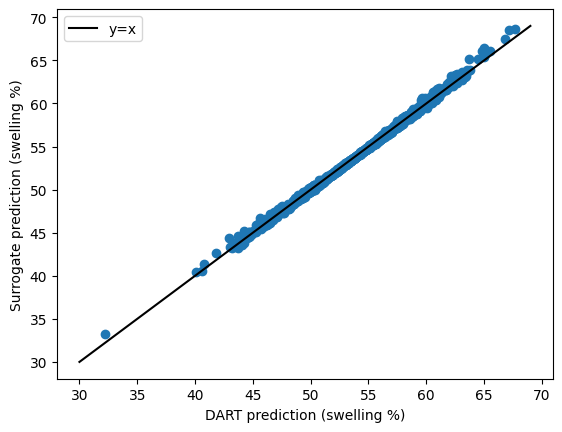

In [14]:
reg_lars = linear_model.LassoLarsCV(cv=5).fit(X_train, y_train)

print(' alpha: ', reg_lasso.alpha_)
lin_coef_cept(reg_lars)
mod_metrics(reg_lars, X_test, y_test)
pred_vs_actual(reg_lars, X_test, y_test)

# Bayesian ridge

 coeffs:  [ 3.32074575e+01 -1.15098424e+01 -3.70049300e+00  2.92646330e-10
  1.81244158e-01  1.93449680e-02  2.67266277e-23] 
 intercept:  44.49175734056205
 R2:  0.9970847208020613 
 RMSE:  0.2534478163504883 
 MAE:  0.17350114944910403


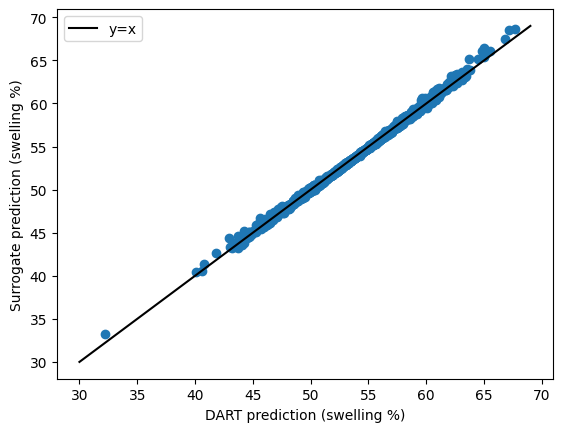

In [15]:
reg_bayr = linear_model.BayesianRidge().fit(X_train, y_train)

lin_coef_cept(reg_bayr)
mod_metrics(reg_bayr, X_test, y_test)
pred_vs_actual(reg_bayr, X_test, y_test)

# ARD

 coeffs:  [ 3.31004399e+01 -1.15191953e+01 -3.71225342e+00  2.72617046e-13
  1.86712598e-01  2.30489915e-02 -6.12155350e-27] 
 intercept:  44.55215249216921
 R2:  0.997132370436354 
 RMSE:  0.251368006807824 
 MAE:  0.17252494424701675


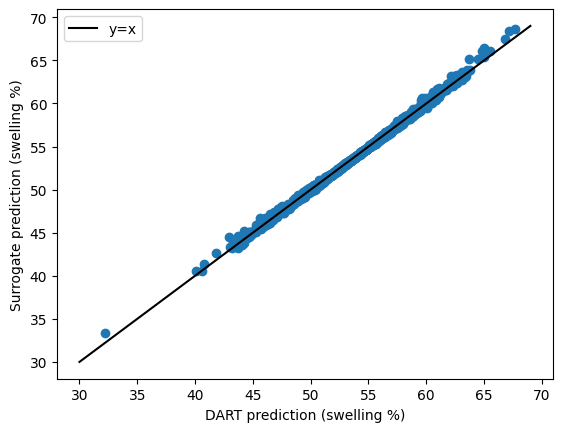

In [16]:
reg_ard = linear_model.ARDRegression().fit(X, y)

lin_coef_cept(reg_ard)
mod_metrics(reg_ard, X_test, y_test)
pred_vs_actual(reg_ard, X_test, y_test)

# GP

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

In [18]:
tX_train, _, ty_train, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=17
)

In [19]:
len(ty_train)

448

In [20]:
kern = DotProduct() + WhiteKernel()
#reg_gp = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=9)
reg_gp = GaussianProcessRegressor(kernel=1.0*RBF(), n_restarts_optimizer=9)
reg_gp.fit(tX_train, ty_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

In [21]:
reg_gp.kernel_

53.9**2 * RBF(length_scale=0.000199)

 R2:  -132.5754435257764 
 RMSE:  54.25150485742116 
 MAE:  54.04804895833333


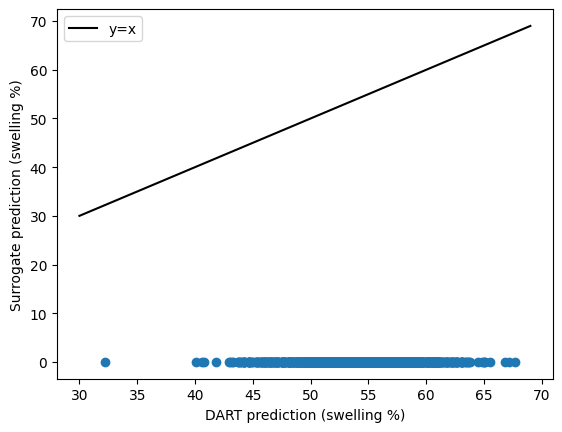

In [22]:
mod_metrics(reg_gp, X_test, y_test)
pred_vs_actual(reg_gp, X_test, y_test)

# NN

In [23]:
from sklearn.neural_network import MLPRegressor

In [24]:
reg_nn = MLPRegressor(
    hidden_layer_sizes=(10, 20, 10),
    alpha=0,
    random_state=37,
    max_iter=5000,
    tol=0.1
).fit(X_train, y_train)

 R2:  0.9402216421911709 
 RMSE:  1.1476790844667453 
 MAE:  0.8772030339484418


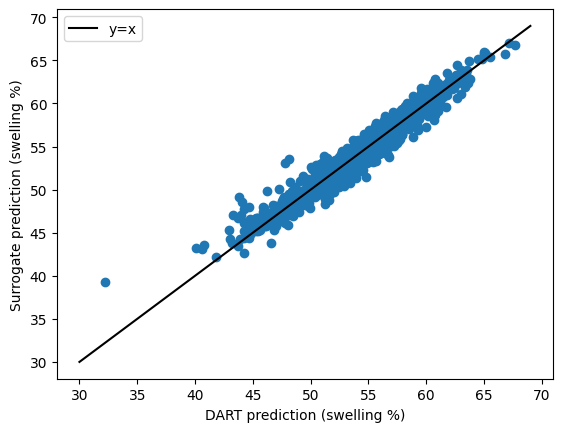

In [25]:
mod_metrics(reg_nn, X_test, y_test)
pred_vs_actual(reg_nn, X_test, y_test)

In [26]:
## Manually updating weights and biases of the NN
## To make it the same as Ordinary Least Squares

#weights = reg_nn.coefs_
#for i, coef in enumerate(weights):
#    print(f'Layer {i} to {i+1}')
#    print(coef)
#
#weights[0][0] = 33.17
#weights[0][1] = -11.5
#weights[0][2] = 3.67
#weights[0][3] = 0
#weights[0][4] = 0.155
#weights[0][5] = 0
#weights[0][6] = 0
#weights[1][0] = 1
#
#biases = reg_nn.intercepts_
#for i, intercept in enumerate(biases):
#    print(f'Layer {i} to {i+1}')
#    print(intercept)
#
#biases[0][0] = 0
#biases[1][0] = 40.51

# SVR

In [27]:
from sklearn.svm import SVR

 R2:  0.9936518251889057 
 RMSE:  0.37400113113489253 
 MAE:  0.17171006231886668


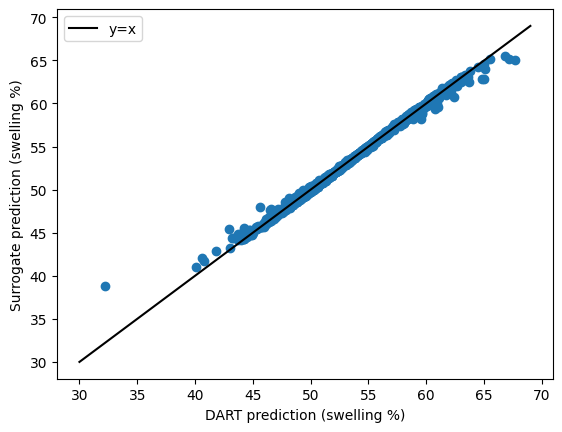

In [28]:
reg_svr = SVR(kernel='rbf').fit(X_train, y_train)

#lin_coef_cept(reg_svr)
mod_metrics(reg_svr, X_test, y_test)
pred_vs_actual(reg_svr, X_test, y_test)

# Target

In [29]:
def swelling_perc(fd):
    #return 6.13e-43 * fd**2 + 4e-21 * fd
    return 3.83e-43 * fd**2 + 4.54e-21 * fd

target = norm(swelling_perc(7e21), 1.25)

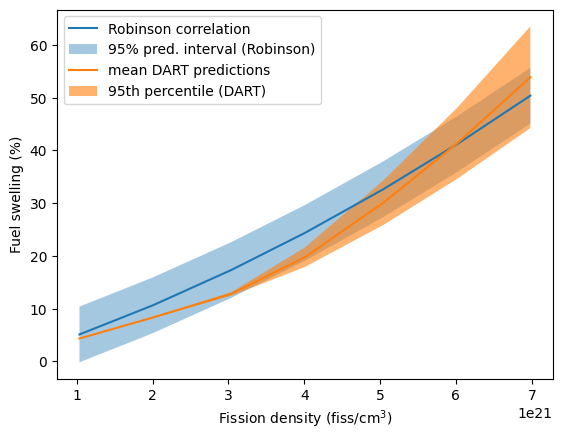

In [30]:
y_exp = [swelling_perc(x) for x in fdVals]

plt.plot(fdVals, y_exp, label='Robinson correlation')
exp_hi = [y + 5.28 for y in y_exp]
exp_lo = [y - 5.28 for y in y_exp]
plt.fill_between(fdVals, exp_lo, exp_hi, alpha=0.4,
                 label='95% pred. interval (Robinson)')

y_mod = []
e_mod = []
for x, data in zip(fdVals, fdData):
    y_mod.append(mean(data['fuel_swelling']))
    e_mod.append(stdev(data['fuel_swelling']))

plt.plot(fdVals, y_mod, label='mean DART predictions')
mod_hi = [i + 2*j for i, j in zip(y_mod, e_mod)]
mod_lo = [i - 2*j for i, j in zip(y_mod, e_mod)]
plt.fill_between(fdVals, mod_lo, mod_hi, alpha=0.6,
                 label='95th percentile (DART)')

plt.xlabel(r'Fission density (fiss/cm$^3$)')
plt.ylabel('Fuel swelling (%)')

plt.legend()
plt.show()

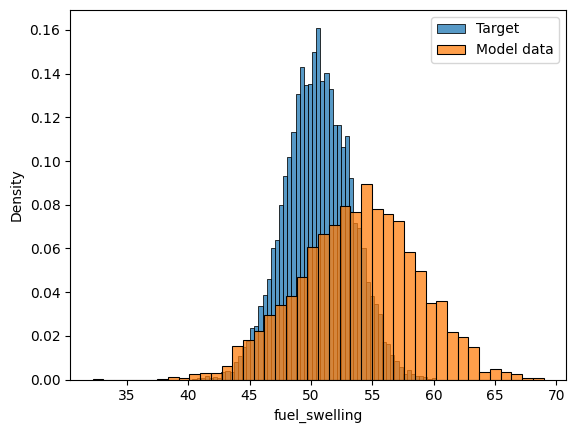

In [31]:
sns.histplot(np.random.normal(swelling_perc(7e21), 2.7, 10000),
             stat='density', label='Target')
sns.histplot(fdData[-1]['fuel_swelling'],
             stat='density', label='Model data')

plt.legend()
plt.show()

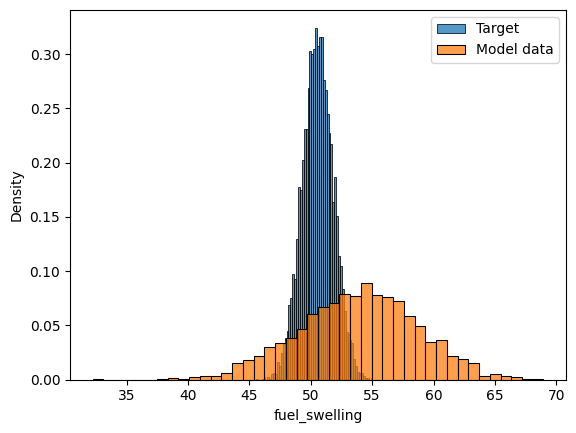

In [32]:
sns.histplot(np.random.normal(swelling_perc(7e21), 1.25, 10000),
             stat='density', label='Target')
sns.histplot(fdData[-1]['fuel_swelling'],
             stat='density', label='Model data')

plt.legend()
plt.show()

# IUQ

In [33]:
def proposal_dist(X, sig):
    ret = []
    
    for el in X:
        prop = 3
        while (prop < 0 or prop > 1):
            prop = np.random.normal(el, sig)
        ret.append(prop)
        
    assert len(X) == len(ret)
    return ret

In [34]:
def mcmc_sampler(num_param, initial_state, proposal_sig,
                 surrogate, target_fn, num_samples):
    samples = [initial_state]
    accepted = 0

    for ii in range(num_samples):
        current_state = samples[-1]
        proposed_state = proposal_dist(current_state, proposal_sig)

        fs_curr = surrogate.predict([[*current_state]])[0]
        fs_prop = surrogate.predict([[*proposed_state]])[0]
        
        acceptance_ratio = target_fn.pdf(fs_prop) / target_fn.pdf(fs_curr)
        
        if np.random.rand() < acceptance_ratio:
            current_state = proposed_state
            accepted += 1

        samples.append(current_state)

    print(f"Acceptance rate: {accepted / num_samples}")
    return np.array(samples)

In [35]:
hey = mcmc_sampler(
    7,
    np.random.rand(7),
    0.20,
    reg_lasso,
    target,
    20000
)

Acceptance rate: 0.228


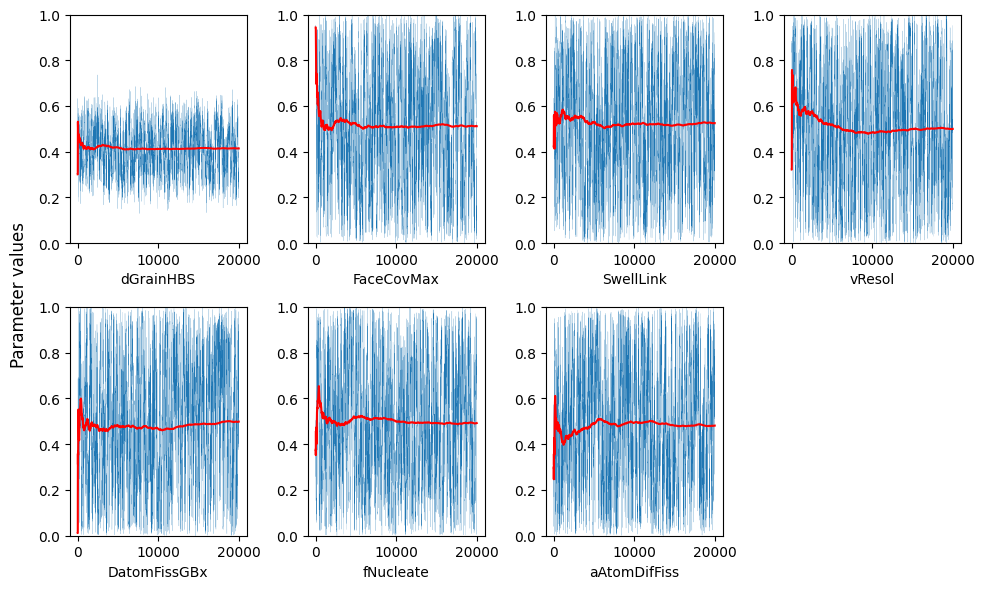

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    cdat = hey[:,i]
    cavg = np.cumsum(cdat) / np.arange(1, len(cdat)+1)
    ax.plot(cdat, lw=0.1, zorder=1)
    ax.plot(cavg, c='r', zorder=2)
    ax.set_xlabel(hi_data.columns[i])
    ax.set_ylim([0, 1])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

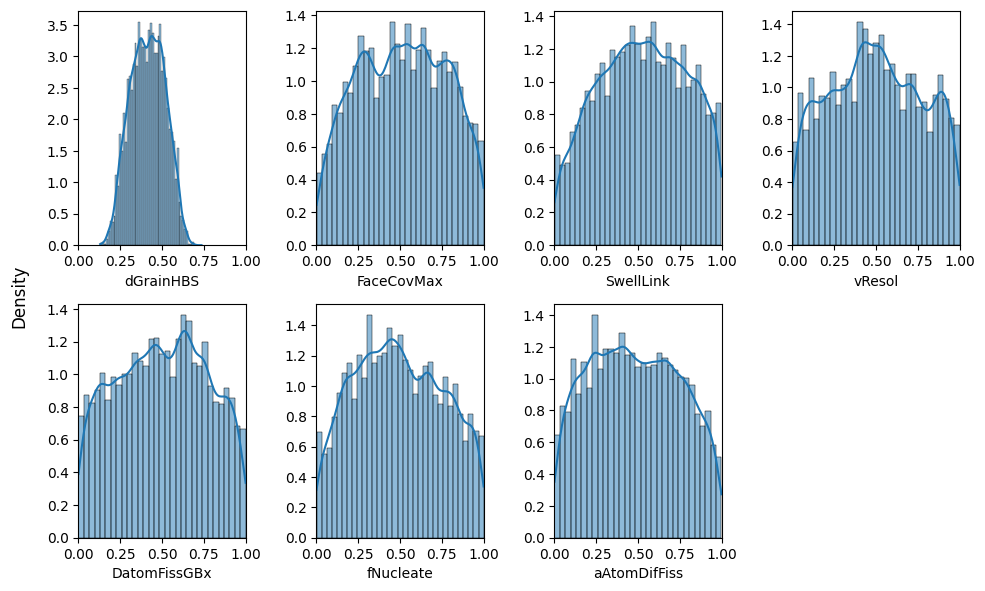

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, stat='density', kde=True)
    ax.set_xlabel(hi_data.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([0, 1])

fig.delaxes(axes[1,3])
fig.supylabel('Density')
plt.tight_layout()
plt.show()

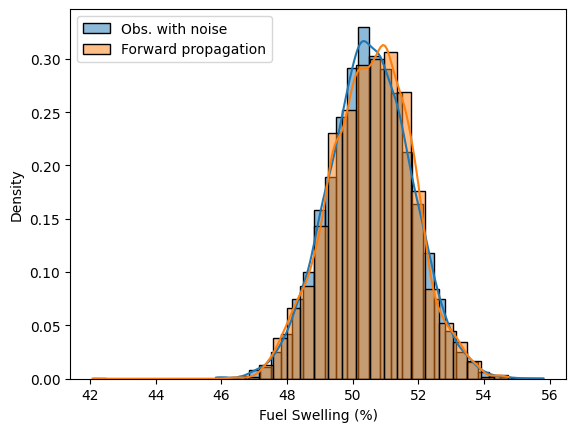

In [38]:
orig = []
res = []
for i in range(10000):
    res.append(reg_lin.predict([hey[-i]])[0])
    c = np.random.normal(swelling_perc(7e21), 1.25)
    orig.append(c)
    
sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')

plt.xlabel('Fuel Swelling (%)')
plt.legend()
plt.show()

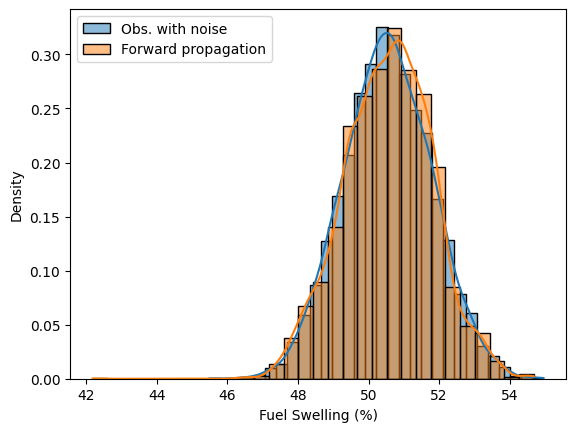

In [39]:
orig = []
res = []
for i in range(10000):
    cpy = copy.deepcopy(hey[-i])
    #cpy[2] = np.random.rand()
    for dd in range(3, 7):
        cpy[dd] = 0.5
        
    res.append(reg_lasso.predict([cpy])[0])
    c = np.random.normal(swelling_perc(7e21), 1.25)
    orig.append(c)
    
sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')

plt.xlabel('Fuel Swelling (%)')
plt.legend()
plt.show()